In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GRU, LSTM, Conv1D, MaxPooling1D, Flatten, Input, concatenate
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

### Генерація даних

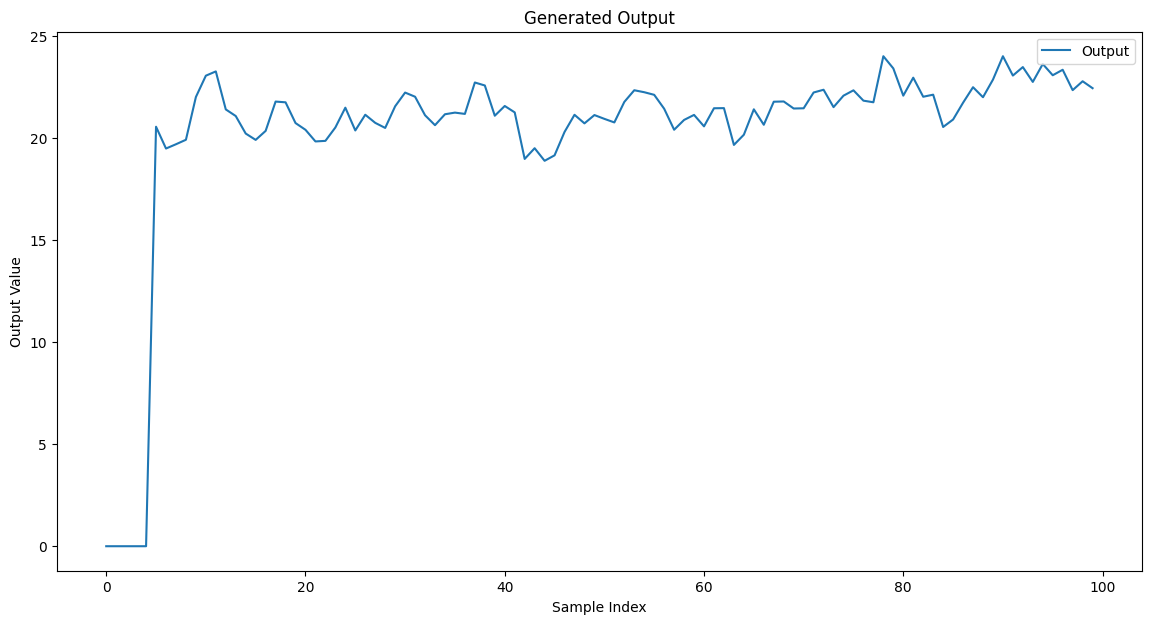

In [17]:
# Параметри
num_samples = 80000
num_inputs = 17

# Генерація випадкових даних
np.random.seed(0)
data = np.random.rand(num_samples, num_inputs)

# Функція для генерації виходу на основі попередніх значень
def generate_output(data):
    output = np.zeros(num_samples)
    for i in range(5, num_samples):
        output[i] = (0.5 * np.sum(data[i-5:i, :]) + np.random.normal(scale=0.1))
    return output

# Генерація виходу
output = generate_output(data)

# Перетворення в DataFrame
df = pd.DataFrame(data, columns=[f'input_{i}' for i in range(num_inputs)])
df['output'] = output
df.to_csv('complex_data.csv', index=False)

# Візуалізація частини даних
plt.figure(figsize=(14, 7))
plt.plot(df['output'][:100], label='Output')
plt.xlabel('Sample Index')
plt.ylabel('Output Value')
plt.title('Generated Output')
plt.legend()
plt.show()

### Розробка нейронної мережі

In [18]:
# Завантаження даних
df = pd.read_csv('complex_data.csv')
data = df.values

In [19]:
# Визначення входів і виходу
X = data[:, :-1]
y = data[:, -1]

In [20]:
# Нормалізація
from sklearn.preprocessing import MinMaxScaler

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

In [21]:
# Параметри для TimeseriesGenerator
time_steps = 10
generator = TimeseriesGenerator(X_scaled, y_scaled, length=time_steps, batch_size=32)


In [22]:
# Створення моделі
model = Sequential([
    Input(shape=(time_steps, num_inputs)),
    GRU(64, return_sequences=True),
    LSTM(32, return_sequences=True),
    LSTM(16, return_sequences=True),
    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Conv1D(32, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


In [23]:
# Тренування моделі
history = model.fit(generator, epochs=10, verbose=1)


Epoch 1/10
  23/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 0.2228

c:\Users\qizixxx\Documents\UNIC\2 course\dubov\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 7ms/step - loss: 0.0078
Epoch 2/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 8.2365e-05
Epoch 3/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 25s 10ms/step - loss: 7.4930e-05
Epoch 4/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 21s 8ms/step - loss: 6.4492e-05
Epoch 5/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 20s 8ms/step - loss: 4.9435e-05
Epoch 6/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 4.9908e-05
Epoch 7/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 5.1533e-05
Epoch 8/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 3.8656e-05
Epoch 9/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 4.1662e-05
Epoch 10/10
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 17s 7ms/step - loss: 3.5996e-05


In [24]:
# Оцінка моделі
loss = model.evaluate(generator)
print(f'Test loss: {loss}')


2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step - loss: 2.1085e-05
Test loss: 2.1096151613164693e-05


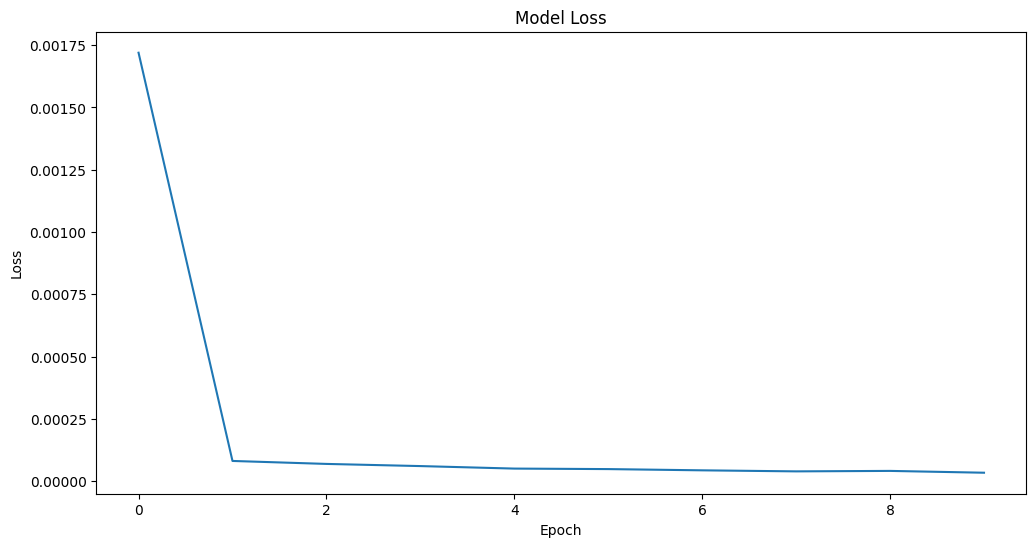

In [25]:
# Візуалізація втрат
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step


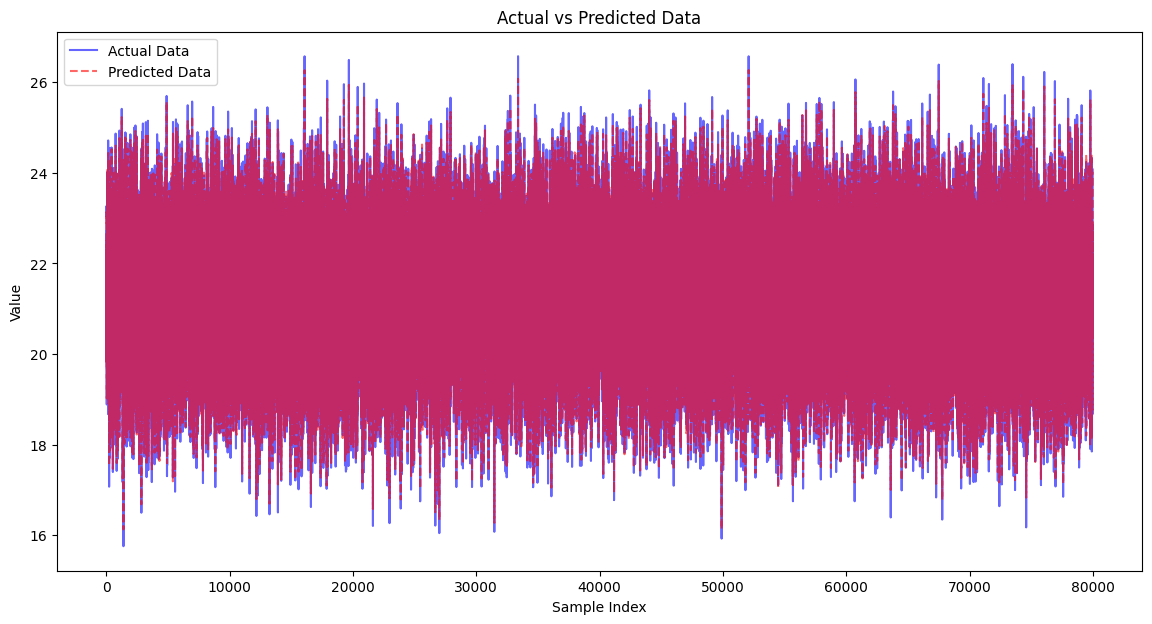

In [31]:
# Функція для створення нових даних для прогнозування
def create_sequences(data, time_steps):
    sequences = []
    for i in range(len(data) - time_steps):
        sequences.append(data[i:i + time_steps])
    return np.array(sequences)

# Створення послідовностей для прогнозування
X_sequences = create_sequences(X_scaled, time_steps)

# Прогнозування
y_pred_scaled = model.predict(X_sequences)  # Прогнозування
y_pred = scaler_y.inverse_transform(y_pred_scaled)  # Декодування прогнозів
y_actual = scaler_y.inverse_transform(y_scaled)  # Декодування реальних значень

# Візуалізація результатів
plt.figure(figsize=(14, 7))
plt.plot(y_actual[-len(y_pred):], label='Actual Data', color='blue', alpha=0.6)  # Реальні дані для останніх зразків
plt.plot(y_pred, label='Predicted Data', linestyle='--', color='red', alpha=0.6)  # Прогнозовані дані
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Data')
plt.legend()
plt.show()
